In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt

from rur import uri, uhmi

# 1. Load Data

Description: https://gemsimulation.com/#/data/datainfo

In [2]:
Repository = "/storage7/NewCluster" # Where NC data is stored
snap = uri.RamsesSnapshot(Repository, 0, z=0.8)
snaps = uri.TimeSeries(snap)

gals = uhmi.HaloMaker.load(snap, galaxy=True)
print(f"{len(gals)} galaxies found")
print(gals.dtype.names)
print()
hals = uhmi.HaloMaker.load(snap, galaxy=False)
print(f"{len(hals)} halos found")
print(hals.dtype.names)
print()

Find nearest iout=620 for z=0.8
[Output 00620] Age (Gyr) : 6.883 / 13.761, z = 0.80011 (a = 0.5555)
5570 galaxies found
('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'sigma_bulge', 'm_bulge', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc')

89994 halos found
('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc')



In [5]:
from rur.utool import load
# For galaxy
ytree = load(f"{Repository}/YoungTree/ytree_light.pickle", format='pkl')
ptree = load(f"{Repository}/ptree/ptree_stable.pkl", format='pkl')
# For halo
# ptree_dm = load(f"{Repository}/ptree_dm/ptree_stable.pkl", format='pkl')
# YoungTree not available for halos

File /storage7/NewCluster/YoungTree/ytree_light.pickle load complete (522.4 MiB): 0.329 seconds elapsed
File /storage7/NewCluster/ptree/ptree_stable.pkl load complete (1.729 GiB): 0.764 seconds elapsed


# 2. Find Branch

In [6]:
target_galaxy = gals[np.argmax(gals['m'])]
print(target_galaxy['id'])

5


- ptree (PhantomTree, developed by San Han): based on the particle membership and track toward finding descendants
- ytree (YoungTree, developed by Seyoung Jeon): based on the particle membership, mass change, and velocity offset. Also it finds fragmented or merged

## Main branch

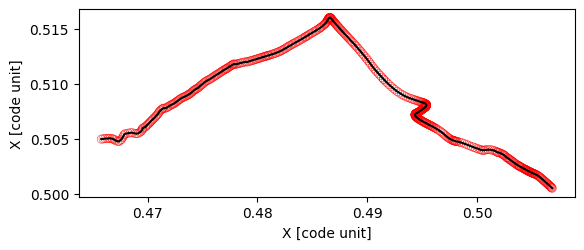

In [30]:
plast = ptree[ptree['timestep'] == snap.iout] # Last timestep
pleaf = plast[plast['hmid'] == target_galaxy['id']][0] # Leaf
pbranch = ptree[ptree['last'] == pleaf['last']]
argsort = np.argsort(pbranch['timestep'])
pbranch = pbranch[argsort]

ylast = ytree[ytree['timestep'] == snap.iout] # Last timestep
yleaf = ylast[ylast['id'] == target_galaxy['id']][0] # Leaf
ybranch = ytree[ytree['last'] == yleaf['last']]
argsort = np.argsort(ybranch['timestep'])
ybranch = ybranch[argsort]

fig, ax = plt.subplots()
ax.plot(pbranch['x'], pbranch['y'], color='k')
ax.scatter(ybranch['x'], ybranch['y'], ec='r', fc='none', lw=0.3)
ax.set_xlabel("X [code unit]")
ax.set_ylabel("X [code unit]")
ax.set_aspect('equal')
plt.show(); plt.close()

## Merged branches

Let's find all mergers (of m>10^9)

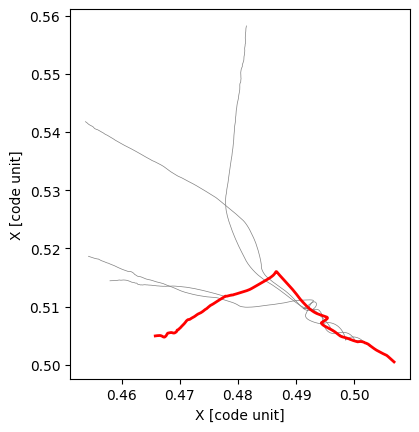

In [27]:
# Ptree

mask = (ptree['son']>0) & (ptree['m'] > 1e9) & (ptree['last'] != pleaf['last'])
# Find any galaxy whose son is in the branch
tmp = np.isin( ptree[mask]['son'], pbranch['id'])
lasts = ptree[mask][tmp]['last']

fig, ax = plt.subplots()
ax.plot(pbranch['x'], pbranch['y'], color='r', zorder=2, lw=2)
for last in lasts:
    pmerged = ptree[ptree['last'] == last]
    argsort = np.argsort(pmerged['timestep'])
    pmerged = pmerged[argsort]
    ax.plot(pmerged['x'], pmerged['y'], color='grey', zorder=1, lw=0.5)
ax.set_xlabel("X [code unit]")
ax.set_ylabel("X [code unit]")
ax.set_aspect('equal')
plt.show(); plt.close()
# If you want to find "merger of merger", iteratively do the same thing

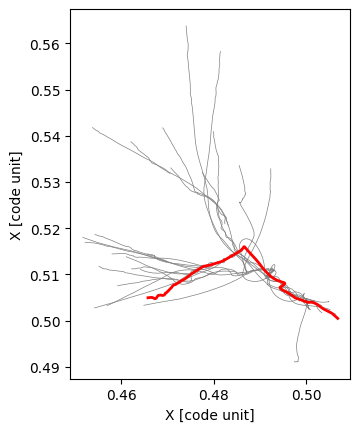

In [29]:
# Ytree
all_merged = ytree[ytree['final'] == yleaf['final']]
lasts, counts = np.unique(all_merged['last'], return_counts=True)
# Choose tree_length > 50
lasts = lasts[counts>50]

fig, ax = plt.subplots()
ax.plot(ybranch['x'], ybranch['y'], color='r', zorder=2, lw=2)
for last in lasts:
    ymerged = ytree[ytree['last'] == last]
    maxm = np.max(ymerged['m'])
    if maxm < 1e9: continue
    argsort = np.argsort(ymerged['timestep'])
    ymerged = ymerged[argsort]
    ax.plot(ymerged['x'], ymerged['y'], color='grey', zorder=1, lw=0.5)
ax.set_xlabel("X [code unit]")
ax.set_ylabel("X [code unit]")
ax.set_aspect('equal')
plt.show(); plt.close()